In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from itertools import product, combinations
%matplotlib inline

In [2]:
def downcast_type(df):
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype == 'int64']
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    
    return df

In [3]:
datadir = '../data/raw'
item_categories = pd.read_csv(os.path.join(datadir, 'item_categories.csv'))
item = pd.read_csv(os.path.join(datadir, 'items.csv'))
train = pd.read_csv(os.path.join(datadir, 'sales_train_v2.csv'))
shops = pd.read_csv(os.path.join(datadir, 'shops.csv'))
test = pd.read_csv(os.path.join(datadir, 'test.csv'))

## Data cleansing and preparation
Remove outliers, aggregate sales by month, filter out shops not included in test data, and mimic test data distribution by including 0 sales shop-item pairs

0     999.00
1     899.00
2     899.00
3    1709.05
Name: item_price, dtype: float64


Text(0.5,1,'item count')

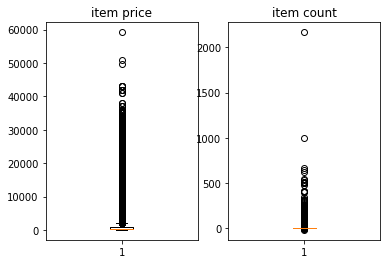

In [4]:
selected = train[train['item_price'] < 100000]['item_price']
print(selected.head(4))
fig, ax = plt.subplots(1, 2)
#fig, ax = plt.subplots()
ax[0].boxplot(selected)
ax[0].set_title('item price')
ax[1].boxplot(train['item_cnt_day'])
ax[1].set_title('item count')

Remove item :
    *  price > 100,000
    *  price < 0
    *  count > 1000

In [5]:
train = train[(train['item_price'] < 100000) & (train['item_price'] > 0) & (train['item_cnt_day'] <= 1000)]

Make sure all shops and item in train are in test

In [6]:
train = train[train['shop_id'].isin(test['shop_id'].unique())]
train = train[train['item_id'].isin(test['item_id'].unique())]

In [7]:
#train.groupby(['date_block_num'])['item_cnt_day','item_price'].apply(lambda x: x.sum())
test[(test['shop_id'] == 59) & (test['item_id'] == 2574)].head(10)

,ID,shop_id,item_id
148320,148320,59,2574


In [8]:
# trying to workout what product does
sh = train[train['date_block_num'] == 1]['shop_id'].unique()
it = train[train['date_block_num'] == 1]['item_id'].unique()
pr = product(sh, it)
np.array(list(pr)).shape

(32436, 2)

In [9]:
# trying to workout what product does
sh = train[train['date_block_num'] == 1]['shop_id'].unique()
it = train[train['date_block_num'] == 1]['item_id'].unique()
pr = product(sh, it, [3])
np.array(list(pr))

array([[   50,  3897,     3],
       [   50,  3851,     3],
       [   50,  3871,     3],
       ...,
       [   28,  8779,     3],
       [   28, 10609,     3],
       [   28, 14110,     3]])

In [10]:
monthly_sales = []
for i in range(34):
    month_sales = train[train['date_block_num'] == i]
    monthly_sales.append(np.array(list(product(month_sales['shop_id'].unique(), month_sales['item_id'].unique(), [i])), dtype='int16'))

index_cols = ['shop_id', 'item_id', 'date_block_num']    
test['date_block_num'] = 34
monthly_sales.append(test[index_cols])

In [12]:
monthly_sales = pd.DataFrame(np.vstack(monthly_sales), columns = index_cols)

In [15]:
monthly_sales.tail(6)

,shop_id,item_id,date_block_num
2946012,45,18027,34
2946013,45,18454,34
2946014,45,16188,34
2946015,45,15757,34
2946016,45,19648,34
2946017,45,969,34


In [19]:
from sklearn import preprocessing

In [41]:
le = preprocessing.LabelEncoder()
le_df = item_categories.copy()
le_df['split'] = item_categories['item_category_name'].str.split('-')
le_df['category_type'] = le_df['split'].map(lambda x: x[0].strip())
le_df['category_type'] = le.fit_transform(le_df['category_type'])
le_df['category_subtype'] = le_df['split'].map(lambda x: ' '.join(x[1:]).strip() if len(x) > 1 else x[0].strip())
le_df['category_subtype'] = le.fit_transform(le_df['category_subtype'])
le_df.drop(columns=['split'], inplace = True)

In [42]:
le_df

,item_category_name,item_category_id,category_type,category_subtype
0,PC - Гарнитуры/Наушники,0,0,31
1,Аксессуары - PS2,1,1,11
2,Аксессуары - PS3,2,1,12
3,Аксессуары - PS4,3,1,13
4,Аксессуары - PSP,4,1,15
5,Аксессуары - PSVita,5,1,16
6,Аксессуары - XBOX 360,6,1,18
7,Аксессуары - XBOX ONE,7,1,19
8,Билеты (Цифра),8,2,28
9,Доставка товара,9,3,35


In [54]:
shops_le = shops.copy()
shops_le['split'] = shops_le['shop_name'].str.split(' ')
shops_le['city_name'] = shops_le['split'].map(lambda x: x[0].strip())
shops_le['city_code'] = le.fit_transform(shops_le['city_name'])
shops_le['short_shop_name'] = shops_le['split'].map(lambda x: ' '.join(x[1:]).strip())
shops_le.drop(columns=['split'], inplace=True)

In [55]:
shops_le

,shop_name,shop_id,city_name,city_code,short_shop_name
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,0,"Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,0,"ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1,"ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2,"ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3,"ТЦ ""Волга Молл"""
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,4,"ТРЦ ""Мармелад"""
6,"Воронеж (Плехановская, 13)",6,Воронеж,5,"(Плехановская, 13)"
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,5,"ТРЦ ""Максимир"""
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,5,"ТРЦ Сити-Парк ""Град"""
9,Выездная Торговля,9,Выездная,6,Торговля


join sales, shops, and item

In [61]:
all_data = pd.merge(monthly_sales, shops_le, how='left', on=['shop_id'])
all_data = pd.merge(all_data, item, how='left', on=['item_id'])
all_data = pd.merge(all_data, le_df, how='left', on=['item_category_id'])

In [62]:
all_data

,shop_id,item_id,date_block_num,shop_name,city_name,city_code,short_shop_name,item_name,item_category_id
0,59,22154,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37
1,59,2574,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",DEL REY LANA Born To Die The Paradise Editio...,55
2,59,2607,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",DEPECHE MODE The Best Of 1,55
3,59,2614,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",DEPECHE MODE Violator,55
4,59,2808,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""","Diablo III [PC, Jewel, русская версия]",30
5,59,2703,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""","Dark Souls: Prepare to Die Edition [PC, Jewel,...",30
6,59,2088,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",CELENTANO ADRIANO Con Giulio Libano E La Sua ...,58
7,59,2090,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",CELENTANO ADRIANO Facciamo Finta Che Sia Vero,55
8,59,2100,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",CELENTANO ADRIANO Per Sempre,55
9,59,2164,0,"Ярославль ТЦ ""Альтаир""",Ярославль,31,"ТЦ ""Альтаир""",CLAPTON ERIC & B.B. KING Riding With The King...,58


## Feature Engineering
Features come from:
    *  Lagged target values for shop/items and mean lagged target values for shop, items, and categories
    *  Interaction between lagged features
    *  Month when sale is happening
    *  Elapsed time since product is in the market or since its last sale
    *  Statistics on how sales on shops and categories behave when new products are introduced
    *  Text features computed from item names

### Get Target
Compute target values as a monthly aggregatino of shop-item sales

In [64]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'shop_name', 'city_name',
       'city_code', 'short_shop_name', 'item_name', 'item_category_id'],
      dtype='object')

In [66]:
all_data.drop(columns=['shop_name', 'city_name', 'item_name', 'short_shop_name'], inplace=True)

In [70]:
group = train.groupby(by=index_cols)['item_cnt_day'].sum()
group.rename(columns={'item_cnt_day': 'target'}, inplace=True)

shop_id  item_id  date_block_num
2        30       2                 1.0
                  5                 1.0
                  15                1.0
                  16                1.0
         31       1                 4.0
                  2                 1.0
                  3                 1.0
                  16                1.0
                  33                1.0
         32       12                1.0
                  14                1.0
                  18                1.0
                  20                2.0
                  21                2.0
                  23                2.0
                  26                1.0
                  31                1.0
         33       0                 1.0
                  10                2.0
                  11                1.0
                  12                1.0
                  20                1.0
                  25                1.0
                  27                1.0
       

In [75]:
group.dtype
#all_data = pd.merge(all_data, group, how='left', on=index_cols)

dtype('float64')